# Maximum Likelihood Estimation (MLE)

## Введение

Maximum Likelihood Estimation (MLE) — это метод оценки параметров статистической модели. Основная идея: найти такие значения параметров, при которых наблюдаемые данные имеют наибольшую вероятность.

### Применение в биологии:
- Оценка частоты мутаций
- Построение филогенетических деревьев
- Анализ экспрессии генов
- Моделирование роста популяций

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## 1. Основы MLE

Для выборки данных $X = \{x_1, x_2, ..., x_n\}$ функция правдоподобия:

$$L(\theta | X) = \prod_{i=1}^{n} f(x_i | \theta)$$

Логарифм правдоподобия (проще для оптимизации):

$$\log L(\theta | X) = \sum_{i=1}^{n} \log f(x_i | \theta)$$

## 2. Пример: Оценка параметров нормального распределения

Представим, что мы измеряем размер определенного белка в клетках.

In [2]:
# Истинные параметры
true_mu = 50  # нм
true_sigma = 10  # нм

# Генерируем данные измерений
n_samples = 100
data = np.random.normal(true_mu, true_sigma, n_samples)

print(f"Истинное среднее: {true_mu}")
print(f"Истинное стандартное отклонение: {true_sigma}")
print(f"\nРазмер выборки: {n_samples}")

Истинное среднее: 50
Истинное стандартное отклонение: 10

Размер выборки: 100


### Аналитическое решение для нормального распределения

Для нормального распределения MLE-оценки имеют аналитическое решение:

$$\hat{\mu}_{MLE} = \frac{1}{n}\sum_{i=1}^{n} x_i$$

$$\hat{\sigma}_{MLE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n} (x_i - \hat{\mu})^2}$$

In [3]:
# Аналитическое решение
mu_mle = np.mean(data)
sigma_mle = np.std(data, ddof=0)  # ddof=0 для MLE оценки

print(f"MLE оценка среднего: {mu_mle:.2f}")
print(f"MLE оценка стандартного отклонения: {sigma_mle:.2f}")

MLE оценка среднего: 48.96
MLE оценка стандартного отклонения: 9.04


### Численная оптимизация

Для более сложных распределений используем численную оптимизацию.

In [12]:
def negative_log_likelihood(params, data):
    """Отрицательный логарифм правдоподобия для нормального распределения"""
    mu, sigma = params
    if sigma <= 0:
        return np.inf
    
    n = len(data)
    nll = n/2 * np.log(2 * np.pi * sigma**2) + np.sum((data - mu)**2) / (2 * sigma**2)
    return nll

# Начальные значения
initial_params = [0, 1]

# Оптимизация
result = minimize(negative_log_likelihood, initial_params, args=(data,), method='L-BFGS-B')

mu_opt, sigma_opt = result.x
print(f"\nЧисленная оптимизация:")
print(f"Оценка среднего: {mu_opt:.2f}")
print(f"Оценка стандартного отклонения: {sigma_opt:.2f}")


Численная оптимизация:
Оценка среднего: 57.46
Оценка стандартного отклонения: 17.24


### Визуализация

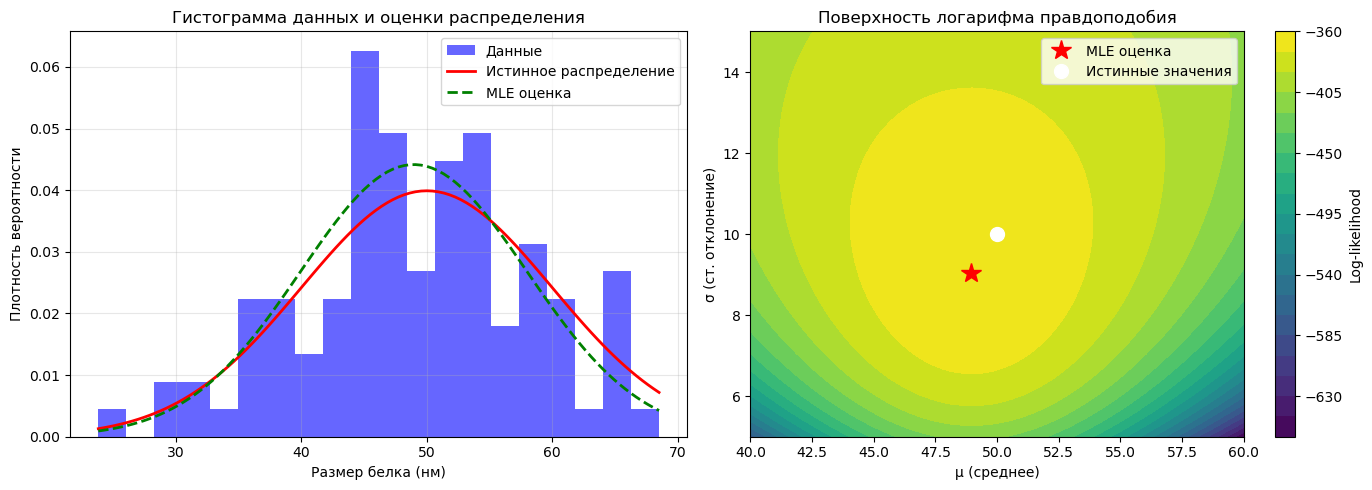

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограмма данных с оценками распределения
axes[0].hist(data, bins=20, density=True, alpha=0.6, color='blue', label='Данные')
x = np.linspace(data.min(), data.max(), 100)
axes[0].plot(x, stats.norm.pdf(x, true_mu, true_sigma), 'r-', lw=2, label='Истинное распределение')
axes[0].plot(x, stats.norm.pdf(x, mu_mle, sigma_mle), 'g--', lw=2, label='MLE оценка')
axes[0].set_xlabel('Размер белка (нм)')
axes[0].set_ylabel('Плотность вероятности')
axes[0].set_title('Гистограмма данных и оценки распределения')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Поверхность логарифма правдоподобия
mu_range = np.linspace(40, 60, 50)
sigma_range = np.linspace(5, 15, 50)
MU, SIGMA = np.meshgrid(mu_range, sigma_range)

LL = np.zeros_like(MU)
for i in range(len(mu_range)):
    for j in range(len(sigma_range)):
        LL[j, i] = -negative_log_likelihood([MU[j, i], SIGMA[j, i]], data)

contour = axes[1].contourf(MU, SIGMA, LL, levels=20, cmap='viridis')
axes[1].plot(mu_mle, sigma_mle, 'r*', markersize=15, label='MLE оценка')
axes[1].plot(true_mu, true_sigma, 'wo', markersize=10, label='Истинные значения')
axes[1].set_xlabel('μ (среднее)')
axes[1].set_ylabel('σ (ст. отклонение)')
axes[1].set_title('Поверхность логарифма правдоподобия')
axes[1].legend()
plt.colorbar(contour, ax=axes[1], label='Log-likelihood')

plt.tight_layout()
plt.show()

## 3. Биологический пример: Оценка частоты мутаций

Предположим, мы секвенировали ДНК нескольких организмов и хотим оценить частоту мутаций на основе биномиального распределения.

In [6]:
# Параметры эксперимента
n_organisms = 50
sequence_length = 1000  # длина секвенированного участка
true_mutation_rate = 0.01  # истинная частота мутаций (1%)

# Генерируем данные: количество мутаций у каждого организма
mutations_per_organism = np.random.binomial(sequence_length, true_mutation_rate, n_organisms)

print(f"Истинная частота мутаций: {true_mutation_rate}")
print(f"Наблюдаемые мутации (первые 10 организмов): {mutations_per_organism[:10]}")

Истинная частота мутаций: 0.01
Наблюдаемые мутации (первые 10 организмов): [ 9  8  6  9 15  8 10 12  9 16]


In [7]:
def binomial_nll(p, n, k_values):
    """Отрицательный логарифм правдоподобия для биномиального распределения"""
    if p <= 0 or p >= 1:
        return np.inf
    
    # Логарифм правдоподобия для биномиального распределения
    log_likelihood = np.sum(stats.binom.logpmf(k_values, n, p))
    return -log_likelihood

# Аналитическое решение для биномиального распределения
p_mle_analytical = np.sum(mutations_per_organism) / (n_organisms * sequence_length)

# Численная оптимизация
result = minimize(binomial_nll, [0.5], args=(sequence_length, mutations_per_organism), 
                  bounds=[(0.001, 0.999)], method='L-BFGS-B')
p_mle_numerical = result.x[0]

print(f"\nАналитическая MLE оценка частоты мутаций: {p_mle_analytical:.4f}")
print(f"Численная MLE оценка частоты мутаций: {p_mle_numerical:.4f}")
print(f"Истинная частота мутаций: {true_mutation_rate:.4f}")


Аналитическая MLE оценка частоты мутаций: 0.0096
Численная MLE оценка частоты мутаций: 0.0096
Истинная частота мутаций: 0.0100


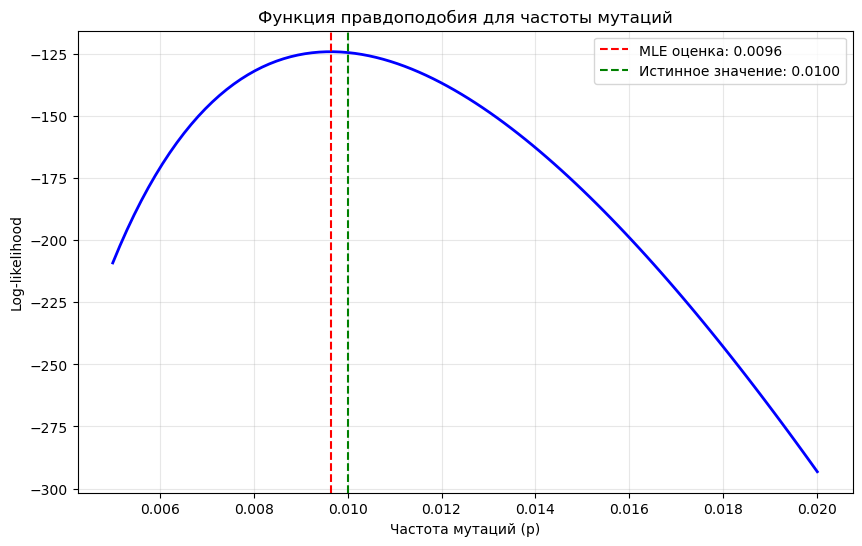

In [8]:
# Визуализация функции правдоподобия
p_values = np.linspace(0.005, 0.02, 100)
likelihoods = [-binomial_nll(p, sequence_length, mutations_per_organism) for p in p_values]

plt.figure(figsize=(10, 6))
plt.plot(p_values, likelihoods, 'b-', lw=2)
plt.axvline(p_mle_analytical, color='r', linestyle='--', label=f'MLE оценка: {p_mle_analytical:.4f}')
plt.axvline(true_mutation_rate, color='g', linestyle='--', label=f'Истинное значение: {true_mutation_rate:.4f}')
plt.xlabel('Частота мутаций (p)')
plt.ylabel('Log-likelihood')
plt.title('Функция правдоподобия для частоты мутаций')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Пример: Распределение Пуассона для подсчета клеток

Распределение Пуассона часто используется для моделирования количества редких событий (например, количество клеток в определенном объеме).

In [9]:
# Истинный параметр (среднее количество клеток)
true_lambda = 15

# Генерируем данные подсчета клеток в разных образцах
n_samples_poisson = 80
cell_counts = np.random.poisson(true_lambda, n_samples_poisson)

# MLE оценка для распределения Пуассона
lambda_mle = np.mean(cell_counts)

print(f"Истинное λ: {true_lambda}")
print(f"MLE оценка λ: {lambda_mle:.2f}")
print(f"\nПримеры подсчетов: {cell_counts[:10]}")

Истинное λ: 15
MLE оценка λ: 14.84

Примеры подсчетов: [13 12 19 15 21 13 17 16  9 15]


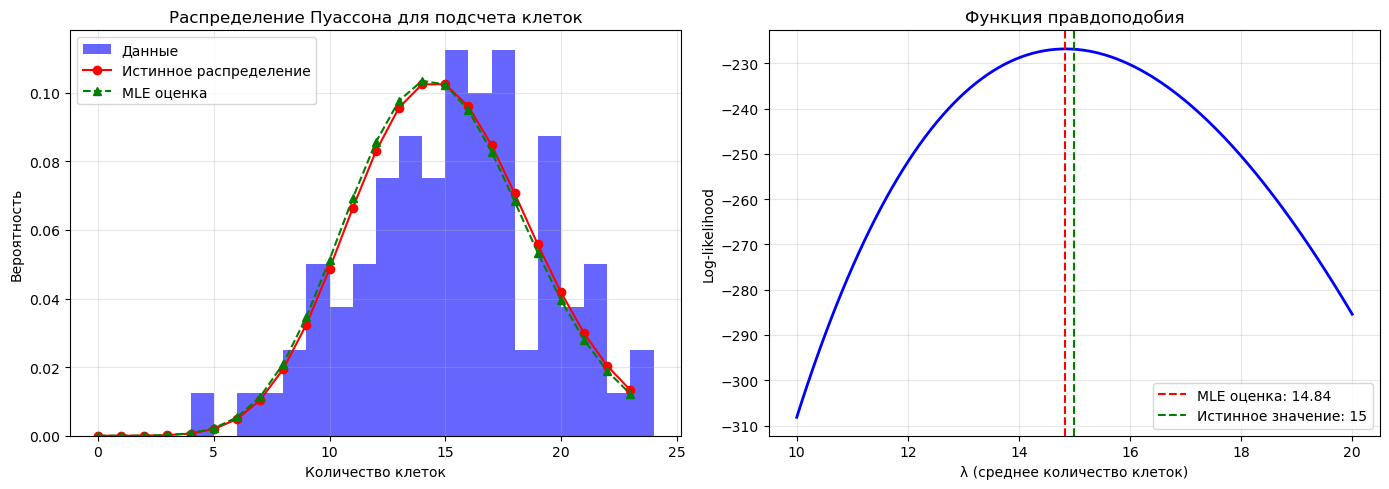

In [10]:
# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограмма данных
axes[0].hist(cell_counts, bins=range(0, max(cell_counts)+2), density=True, alpha=0.6, color='blue', label='Данные')
x_poisson = np.arange(0, max(cell_counts)+1)
axes[0].plot(x_poisson, stats.poisson.pmf(x_poisson, true_lambda), 'ro-', label='Истинное распределение')
axes[0].plot(x_poisson, stats.poisson.pmf(x_poisson, lambda_mle), 'g^--', label='MLE оценка')
axes[0].set_xlabel('Количество клеток')
axes[0].set_ylabel('Вероятность')
axes[0].set_title('Распределение Пуассона для подсчета клеток')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Функция правдоподобия
lambda_range = np.linspace(10, 20, 100)
log_likelihoods = [np.sum(stats.poisson.logpmf(cell_counts, lam)) for lam in lambda_range]

axes[1].plot(lambda_range, log_likelihoods, 'b-', lw=2)
axes[1].axvline(lambda_mle, color='r', linestyle='--', label=f'MLE оценка: {lambda_mle:.2f}')
axes[1].axvline(true_lambda, color='g', linestyle='--', label=f'Истинное значение: {true_lambda}')
axes[1].set_xlabel('λ (среднее количество клеток)')
axes[1].set_ylabel('Log-likelihood')
axes[1].set_title('Функция правдоподобия')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()